##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Core API 快速入门

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/core/quickstart_core"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/quickstart_core.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/quickstart_core.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/core/quickstart_core.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

本快速入门教程演示了如何使用 [TensorFlow Core 低级 API](https://tensorflow.google.cn/guide/core) 来构建和训练预测燃油效率的多元线性回归模型。它使用 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external} 数据集，其中包含 20 世纪 70 年代末和 20 世纪 80 年代初汽车的燃油效率数据。

您将遵循机器学习过程的典型阶段：

1. 加载数据集。
2. 构建[输入流水线](../data.ipynb)。
3. 构建多元[线性回归](https://developers.google.com/machine-learning/glossary#linear-regression){:.external}模型。
4. 评估模型的性能。

## 安装

首先，导入 TensorFlow 和其他必要的库：

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 22:12:24.670018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:12:24.670122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:12:24.670133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TensorFlow version: 2.11.0


## 加载和预处理数据集

接下来，您需要从 [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/){:.external} 加载和预处理 [Auto MPG 数据集](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external}。该数据集使用气缸、排量、马力和重量等各种定量和分类特征来预测 20 世纪 70 年代末和 20 世纪 80 年代初汽车的燃油效率。

数据集包含一些未知值。确保使用 `pandas.DataFrame.dropna` 去除任何缺失值，并使用 `tf.convert_to_tensor` 和 `tf.cast` 函数将数据集转换为 `tf.float32` 张量类型。

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna()
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32)
dataset.tail()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

接下来，将数据集拆分为训练集和测试集。确保使用 <code>tf.random.shuffle</code> 重排数据集，以避免有偏差的拆分。

In [4]:
dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

通过对 `"Origin"` 特征进行独热编码来执行基本[特征工程](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering)。`tf.one_hot` 函数可用于将此分类列转换为 3 个单独的二进制列。

In [5]:
def onehot_origin(x):
  origin = tf.cast(x[:, -1], tf.int32)
  # Use `origin - 1` to account for 1-indexed feature
  origin_oh = tf.one_hot(origin - 1, 3)
  x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
  return x_ohe

x_train_ohe, x_test_ohe = onehot_origin(x_train), onehot_origin(x_test)
x_train_ohe.numpy()

array([[  4., 140.,  72., ...,   1.,   0.,   0.],
       [  4., 120.,  74., ...,   0.,   0.,   1.],
       [  4., 122.,  88., ...,   0.,   1.,   0.],
       ...,
       [  8., 318., 150., ...,   1.,   0.,   0.],
       [  4., 156., 105., ...,   1.,   0.,   0.],
       [  6., 232., 100., ...,   1.,   0.,   0.]], dtype=float32)

此示例显示了一个多元回归问题，其中预测器或特征具有截然不同的尺度。因此，标准化数据以使每个特征具有零均值和单位方差会有所帮助。使用 `tf.reduce_mean` 和 `tf.math.reduce_std` 函数进行标准化。然后，可以对回归模型的预测进行非标准化以获得其用原始单位表示的值。

In [6]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.math.reduce_mean(x, axis=0)
    self.std = tf.math.reduce_std(x, axis=0)

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [7]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)
x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

## 构建机器学习模型

使用 TensorFlow Core API 构建线性回归模型。多元线性回归的方程如下：

$${\mathrm{Y}} = {\mathrm{X}}w + b$$

其中

- $\underset{m\times 1}{\mathrm{Y}}$：目标向量
- $\underset{m\times n}{\mathrm{X}}$：特征矩阵
- $\underset{n\times 1}w$：权重向量
- $b$：偏差

通过使用 `@tf.function` 装饰器，跟踪相应的 Python 代码以生成可调用的 TensorFlow 计算图。这种方式有利于在训练后保存和加载模型。它还可以为具有多层和复杂运算的模型带来性能提升。 

In [8]:
class LinearRegression(tf.Module):

  def __init__(self):
    self.built = False

  @tf.function
  def __call__(self, x):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weight vector and bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_b = tf.random.uniform(shape=[])
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    y = tf.add(tf.matmul(x, self.w), self.b)
    return tf.squeeze(y, axis=1)

对于每个样本，该模型通过计算其特征的加权和加上一个偏差项来返回对输入汽车 MPG 的预测值。然后，可以对该预测值进行非标准化以获得其用原始单位表示的值。

In [9]:
lin_reg = LinearRegression()
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)
prediction_unnorm.numpy()

array([6.8007374], dtype=float32)

## 定义损失函数

现在，定义一个损失函数来评估模型在训练过程中的性能。

由于回归问题处理的是连续输出，均方误差 (MSE) 是损失函数的理想选择。MSE 由以下方程定义：

$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$$

其中

- $\hat{y}$：预测向量
- $y$：真实目标向量

此回归问题的目标是找到最小化 MSE 损失函数的最优权重向量 $w$ 和偏差 $b$。 

In [10]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

## 训练并评估模型

使用 mini-batch 进行训练既可以提高内存效率，又能加快收敛速度​​。`tf.data.Dataset` API 具有用于批处理和重排的有用函数。借助该 API，您可以从简单、可重用的部分构建复杂的输入流水线。在[此指南](https://tensorflow.google.cn/guide/data)中详细了解如何构建 TensorFlow 输入流水线。

In [11]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

接下来，编写一个训练循环，通过使用 MSE 损失函数及其相对于输入参数的梯度来迭代更新模型的参数。

这种迭代方法称为[梯度下降](https://developers.google.com/machine-learning/glossary#gradient-descent){:.external}。在每次迭代中，模型的参数通过在其计算梯度的相反方向上迈出一步来更新。这一步的大小由学习率决定，学习率是一个可配置的超参数。回想一下，函数的梯度表示其最陡上升的方向；因此，向相反方向迈出一步表示最陡下降的方向，这最终有助于最小化 MSE 损失函数。

In [12]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_losses_test = [], []

  # Iterate through the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = lin_reg(x_batch)
      batch_loss = mse_loss(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, lin_reg.variables)
    for g,v in zip(grads, lin_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance 
    batch_losses_train.append(batch_loss)
  
  # Iterate through the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = lin_reg(x_batch)
    batch_loss = mse_loss(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance 
    batch_losses_test.append(batch_loss)

  # Keep track of epoch-level model performance
  train_loss = tf.reduce_mean(batch_losses_train)
  test_loss = tf.reduce_mean(batch_losses_test)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")

Mean squared error for step 0: 2.866


Mean squared error for step 10: 0.453


Mean squared error for step 20: 0.285


Mean squared error for step 30: 0.231


Mean squared error for step 40: 0.209


Mean squared error for step 50: 0.203


Mean squared error for step 60: 0.194


Mean squared error for step 70: 0.184


Mean squared error for step 80: 0.186


Mean squared error for step 90: 0.176



Final train loss: 0.177
Final test loss: 0.157


绘制 MSE 损失随时间变化的图。计算指定[验证集](https://developers.google.com/machine-learning/glossary#validation-set){:.external}或[测试集](https://developers.google.com/machine-learning/glossary#test-set){:.external}上的性能指标可确保模型不会对训练数据集过拟合，并且可以很好地泛化到未知数据。

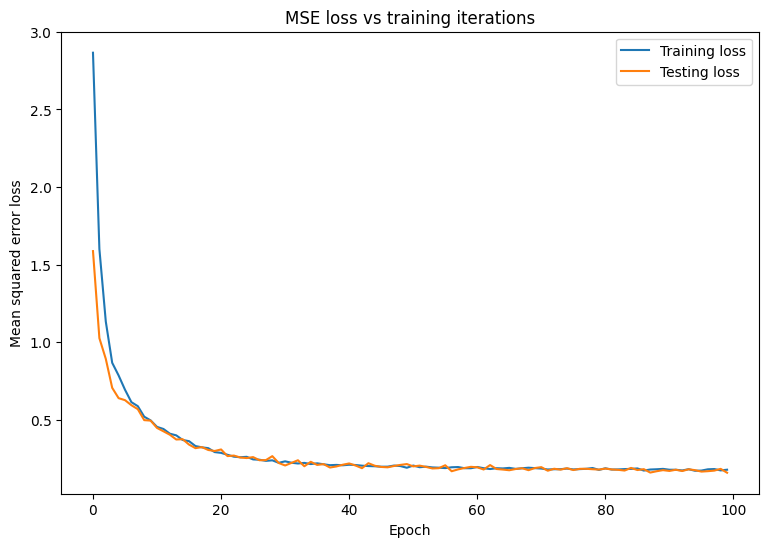

In [13]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

看起来该模型在拟合训练数据方面做得很好，同时也良好地泛化了未知测试数据。

## 保存和加载模型

首先，构建一个接受原始数据并执行以下运算的导出模块：

- 特征提取
- 归一化
- 预测
- 非归一化

In [14]:
class ExportModule(tf.Module):
  def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
    self.model = model
    self.extract_features = extract_features
    self.norm_x = norm_x
    self.norm_y = norm_y

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.extract_features(x)
    x = self.norm_x.norm(x)
    y = self.model(x)
    y = self.norm_y.unnorm(y)
    return y 

In [15]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

如果要将模型保存为当前状态，请使用 `tf.saved_model.save` 函数。要加载保存的模型并进行预测，请使用 `tf.saved_model.load` 函数。

In [16]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpu42sjkv0/lin_reg_export/assets


In [17]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

array([28.097498, 26.193336, 33.564373, 27.719315, 31.787924, 24.014559,
       24.421043, 13.45958 , 28.562454, 27.368694], dtype=float32)

## 结论

恭喜！您已经使用 TensorFlow Core 低级 API 训练了一个回归模型。

有关使用 TensorFlow Core API 的更多示例，请查看以下指南：

- 二元分类的[逻辑回归](./logistic_regression_core.ipynb)
- 用于手写数字识别的[多层感知器](./mlp_core.ipynb)
